In [44]:
import numpy as np
import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
import pycombo
import time

def plotdataset(G:nx.Graph):
    nx.draw(G)
    plt.show()


def Q2(G1:nx.Graph):
    #calculate matrix Q with diag set to 0
    A=np.array(nx.adjacency_matrix(G1).todense())
    T=A.sum(axis=(0,1))
    Q=A*0
    w_in=A.sum(axis=1)
    w_out=w_in.reshape(w_in.shape[0],1)
    K=w_in*w_out/T
    Q=(A-K)/T

    return Q

def Optimizer(method="SGD",constants={'learning_rate':5e-4,'epsilon':1e-7}):
    learning_rate=constants['learning_rate']

    if method =="SGD":
        return tf.keras.optimizers.SGD(learning_rate=learning_rate)

def Constraint(norms):

    return lambda x: tf.clip_by_norm(x,clip_norm=norms,axes=0)


def Loss(C,Q,regulerization=0):

    return -tf.linalg.trace(tf.matmul(tf.matmul(tf.transpose(C),Q),C))

def GD_dev2(Q,G):
    #set Qii to zero for every i
    Q_ori = Q.copy()
    for i in range(Q.shape[0]):
        Q[i][i]=0
    #Hyperparams
    epsilon=1e-7
    learning_rate=5e-3
    num_epoch = 100000
    display_ratio = 1/100

    #Variable Inits
    np.random.seed(2)
    C_init=Q[0:2]*0
    C_init[0]=np.random.randint(2, size=(1,Q.shape[0]))
    C_init[1]=1-C_init[0]
    C_init=C_init.T

    #Constant Initialization
    Q = tf.constant(Q,dtype=tf.float64)

    #variable definition
    C=tf.Variable(initial_value=tf.constant(C_init),dtype=tf.float64,constraint=Constraint(1))
    variables=[C]

    #buffers for loss function 
    L=[]

    #optimization
    optimizer = Optimizer(constants={'learning_rate':learning_rate})
    t1=time.time()
    for e in range(num_epoch):
        with tf.GradientTape() as tape:
            # loss is for minimizaing modularity with a regularization
            loss = Loss(C,Q)
        if -loss>0:
            L.append(-loss.numpy())
        grads = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(grads, variables))

        if e%(int(num_epoch*display_ratio))==0:
            loss_values=Loss(C,Q)
            print('modularity ',-loss_values.numpy(),' on iteration',e,Q.numpy().mean())

        #update rate small then 0.001% then break
        if len(L)>2 and abs(1-L[-1]/L[-2])<0.000001:
            print('convergence')
            break
    t2=time.time()
    
    #assign C to a binary attachment result
    result= {}
    C_numpy=C.numpy()
    label_list=list(G.nodes())
    for i in range(C.shape[0]):
        if C[i][0]>C[i][1]:
            result[label_list[i]]=1
            C_numpy[i][0]=1
            C_numpy[i][1]=0
        else:
            C_numpy[i][0]=0
            C_numpy[i][1]=1
            result[label_list[i]]=0
    #calculate modularity after assigning C to binary values, using original Q with recovered diag
    modularity_1=Modularity(C_numpy,Q_ori)
    modularity_2=Modularity(C.numpy(),Q_ori)
    modularity_3 =Modularity(C.numpy(),Q)
    modularity=[modularity_1,modularity_2,modularity_3]
    return L,modularity,result,int(t2-t1),e
def Modularity(C:np.array,Q):
    C_T=np.transpose(C)
    result = np.trace(np.dot(np.dot(C_T,Q),C))
    return result
def Visual(L):
    #Loss plotting
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(L)
    plt.xlabel("Iteration", fontsize=14)
    plt.ylabel("Modularity", fontsize=14)
    #plt.legend()
    plt.show()

modularity  -0.00022293938563266454  on iteration 0 4.308197347856652e-05
modularity  0.002151166224543425  on iteration 1000 4.308197347856652e-05
modularity  0.004905842717929827  on iteration 2000 4.308197347856652e-05
modularity  0.008362442427551672  on iteration 3000 4.308197347856652e-05
modularity  0.012908165616659162  on iteration 4000 4.308197347856652e-05
modularity  0.01890053130822123  on iteration 5000 4.308197347856652e-05
modularity  0.026445555258837666  on iteration 6000 4.308197347856652e-05
modularity  0.03513120965217873  on iteration 7000 4.308197347856652e-05
modularity  0.04400373218147538  on iteration 8000 4.308197347856652e-05
modularity  0.05198160164884201  on iteration 9000 4.308197347856652e-05
modularity  0.05838784459525328  on iteration 10000 4.308197347856652e-05
modularity  0.06311659916151638  on iteration 11000 4.308197347856652e-05
modularity  0.06642947002850952  on iteration 12000 4.308197347856652e-05
modularity  0.06869228556354334  on iterat

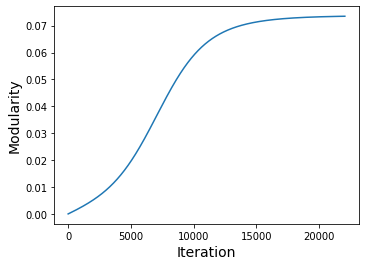

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 1, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 0, 17: 0, 18: 1, 19: 0, 20: 1, 21: 0, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1} 0.37146614069691
[0.37146614069691, 0.06237603784067661, 0.07350050833895466]
({'Napoleon': 0, 'Myriel': 0, 'MlleBaptistine': 0, 'MmeMagloire': 0, 'CountessDeLo': 0, 'Geborand': 0, 'Champtercier': 0, 'Cravatte': 0, 'Count': 0, 'OldMan': 0, 'Valjean': 1, 'Labarre': 1, 'Marguerite': 1, 'MmeDeR': 1, 'Isabeau': 1, 'Gervais': 1, 'Listolier': 1, 'Tholomyes': 1, 'Fameuil': 1, 'Blacheville': 1, 'Favourite': 1, 'Dahlia': 1, 'Zephine': 1, 'Fantine': 1, 'MmeThenardier': 1, 'Thenardier': 1, 'Cosette': 1, 'Javert': 1, 'Fauchelevent': 1, 'Bamatabois': 1, 'Perpetue': 1, 'Simplice': 1, 'Scaufflaire': 1, 'Woman1': 1, 'Judge': 1, 'Champmathieu': 1, 'Brevet': 1, 'Chenildieu': 1, 'Cochepaille': 1, 'Pontmercy': 1, 'Boulatruelle': 1, 'Eponine': 1, 'Anzelma': 1, 'Woman2': 1, 'MotherI

In [45]:
G1=nx.karate_club_graph()
G2=nx.les_miserables_graph()
L,modularity,result,T,e=(GD_dev2(Q2(G1),G1))
print('take {}s with {} iterations'.format(T,e))
Visual(L)
print(result,modularity[0])
print(modularity)
m = pycombo.execute(G2,max_communities=2)
print(m)